In [1]:
# Import packages

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

### Aula 1 - Importação e Instalação das Bibliotecas

In [8]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

In [9]:
vertices = [(0,0), (0,1), (1,1), (1,0)]

quadrado = Polygon(vertices)

gdf = gpd.GeoDataFrame(geometry=[quadrado])

gdf

,geometry
0,"POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1...."


<Axes: >

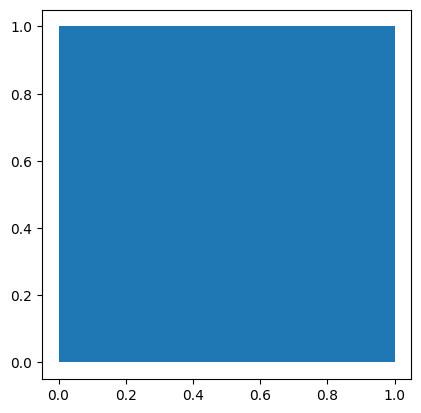

In [12]:
gdf.plot()

### Aula 2 - Primeiro exemplo e Contato com o Geopandas

In [16]:
br_mun = gpd.read_file("malhas_digitais\BR_Municipios_2022.shp")

<Axes: >

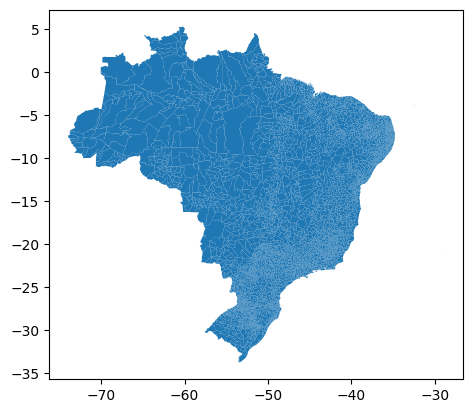

In [17]:
br_mun.plot()

### Aula 3 - Criando Mapa Temático de Taxa de Mortalidade Infantil

In [2]:
def ibge_verification_code(cod_ibge6: str) -> str:
    """Return the IBGE verification code for a 6-digit IBGE code.
    
    The IBGE verification code is a single digit that is added to the end of a 6-digit
    IBGE code to create a valid 7-digit IBGE code. The calculation of the verification
    code is based on the Luhn algorithm, which is used to validate credit card numbers
    and other identification numbers.
    
    Args:
        cod_ibge6: A string containing a 6-digit IBGE code.
    
    Returns:
        A string containing a 7-digit IBGE code, with the verification code added to
        the end.
    
    Raises:
        ValueError: If the input is not a 6-digit string of digits.
    
    Examples:
        >>> ibge_verification_code('110001')
        '1100015'
        
        >>> ibge_verification_code('432803')
        '4328034'
        
        >>> ibge_verification_code('12')
        Traceback (most recent call last):
            ...
        ValueError: Input must be a 6-digit string of digits.
    """
    if not cod_ibge6.isdigit() or len(cod_ibge6) != 6:
        raise ValueError("Input must be a 6-digit string of digits.")
    
    digits = [int(cod_ibge6[i]) * 2 if i % 2 != 0 else int(cod_ibge6[i]) for i in range(6)]
    last_digit = sum(d // 10 + d % 10 for d in digits)
    verification_digit = (10 - last_digit % 10) % 10
    return cod_ibge6 + str(verification_digit)

In [3]:
# Read BR Mun Shapefile
br_mun = gpd.read_file("malhas_digitais\BR_Municipios_2022.shp")

# Import TMI Dataset
tmi_br = pd.read_csv('https://raw.githubusercontent.com/balaio-cientifico/dataset/main/tmi_2020.csv',
                     encoding='ANSI', sep=';')

In [4]:
tmi_br['cod_ibge7'] = tmi_br['cod_ibge'].astype(str).apply(ibge_verification_code)

In [5]:
# Merges two dataframes, br_mun and tmi_br, on the columns 'CD_MUN' and 'cod_ibge7', respectively, and returns a new dataframe called tmi_map.
tmi_map = br_mun.merge(tmi_br, left_on='CD_MUN', right_on='cod_ibge7')

# Removes the columns 'SIGLA_UF', 'AREA_KM2', 'geometry', 'cod_ibge', 'nom_mun', and 'cod_ibge7' from the tmi_map dataframe.
tmi_map.drop(['SIGLA_UF', 'AREA_KM2', 'cod_ibge',
       'nom_mun', 'cod_ibge7'], axis=1, inplace=True)

# Renames the columns 'CD_MUN' and 'NM_MUN' to 'cod_ibge' and 'nome_mun', respectively, in the tmi_map dataframe.
tmi_map.rename({
    "CD_MUN":"cod_ibge",
    "NM_MUN":"nome_mun"
}, axis=1, inplace=True)

#### Create the TMI Map

<Axes: >

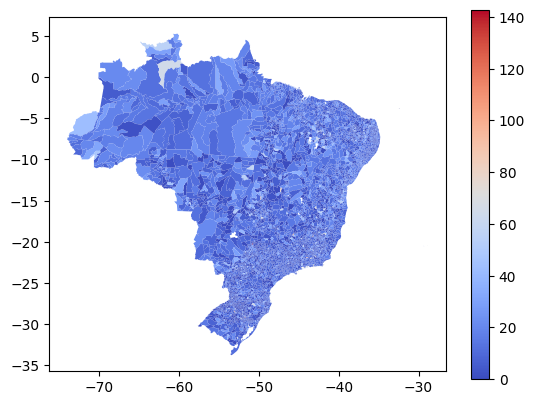

In [22]:
# Create the first map
tmi_map.plot(column='tmi', cmap='coolwarm', legend=True)

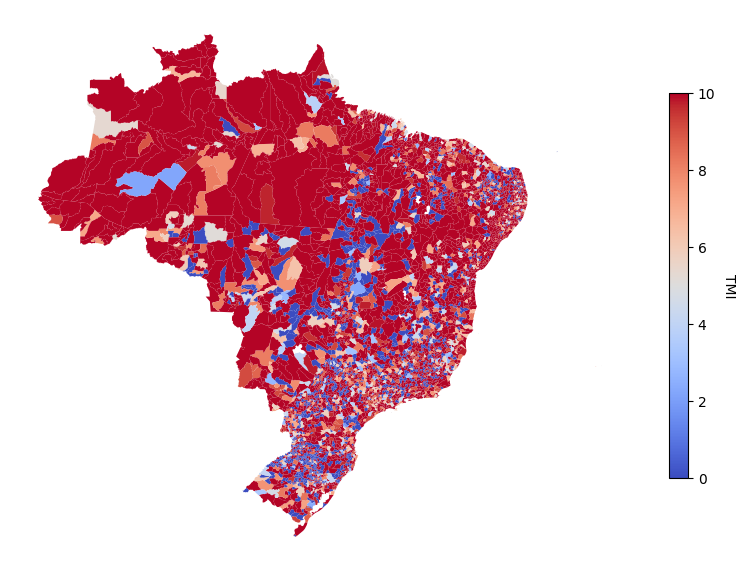

In [21]:
# Set up the color map
cmap = plt.cm.coolwarm
cmap.set_under('white')  # Set color for values below vmin

cmin, cmax = tmi_map['tmi'].min(), tmi_map['tmi'].max()
vmin, vmax = max(0, cmin), min(10, cmax)  # Set limits for color scale

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
tmi_map.plot(column='tmi', cmap=cmap, vmin=vmin, vmax=vmax, missing_kwds=dict(color=missing_color), ax=ax)

# Add a legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('TMI', rotation=270, labelpad=15)

plt.axis('off')
plt.show()